This code is based on https://github.com/kimiandj/gsw

In [1]:
import numpy as np
import torch
from torch import optim
import ot
import pandas as pd
from tqdm import tqdm
from IPython import display
import time
import timeit
import matplotlib.pyplot as pl

In [2]:
import os
import sys
sys.path.append('../code/')

In [3]:
from gradient_flow import GF
from utils_GF import load_data,w2
from SWGG import SWGG_smooth,get_SWGG_smooth

### We choose a dataset and load it
### The dataset name must be 'gaussian_2d', 'gaussian_500d', 'swiss_roll', 'half_moons', 'circle', '8gaussians' or '25gaussians'

/home/gui/Documents/Thèse/Github/SWGG/Notebook/../code/utils_GF.py:29: RuntimeWarning: covariance is not positive-semidefinite.
  temp=np.random.multivariate_normal(mu_s, cov_s, N)


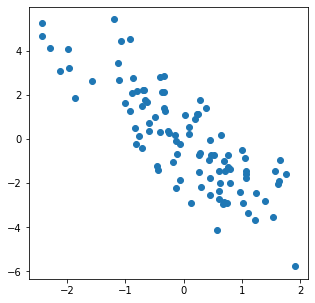

In [4]:
dataset_name = 'gaussian_2d'
seed=0

np.random.seed(seed)
N = 100  # Number of samples from p_X
X = load_data(name=dataset_name, n_samples=N,dim=2)
X -= X.mean(dim=0)[np.newaxis,:]  # Normalization
#X-=torch.tensor([5,5])
meanX = 0

# Show the dataset
_, d = X.shape
fig = pl.figure(figsize=(5,5))
pl.scatter(X[:,0], X[:,1])
pl.show()

### We create the different folders to store the results

In [5]:
results_folder = './Results/Gradient_Flow'
if not os.path.isdir(results_folder):
    os.mkdir(results_folder)
foldername = os.path.join(results_folder, 'Gifs')
if not os.path.isdir(foldername):
    os.mkdir(foldername)
    
foldername = os.path.join(results_folder, 'Gifs', dataset_name + '_Comparison')
if not os.path.isdir(foldername):
    os.mkdir(foldername)

### We solve the two optimization problems for different defining functions and plot the results at each step

In [6]:
# Use GPU if available, CPU otherwise
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device='cpu'
print(device)

cpu


### experimental parameters
#### n =100 points
- gaussian 2d (100 points) : lr = 1e-2, 500 projections, max-sw: lr = 1e-2, 200 iterations, swgg: lr = 1e-2, 200 iters, s=10, std = 0.5
- gaussian 2d (1000 points) : idem
- gaussian 200d (100 points) : 
- 8 gaussians : lr = 1e-2, 500 projections, max-sw: lr = 1e-2, 200 iterations, swgg: lr = 1e-2, 200 iters, s=10, std=0.1
- two moons: lr = 
a marche une fois avec 50 points et l,theta[k],loss_min=gsw_res[k].get_minSW_smooth(X.to(device),Y[k].to(device),lr=1e-2,num_iter=400,s=50,std=0.1, init=theta_optim) + global lr = 2e-3
- swiss roll, lr=1e-2,num_iter=400,s=10,std=0.5, pas d'init pour theta optim
            
            


In [7]:
import importlib
import gradient_flow
importlib.reload(gradient_flow)
np.random.seed(seed)

# Number of iterations for the optimization process
nofiterations = 5000

modes = ['linear', 'linear', 'linear','linear','linear']
titles = ['SW', 'maxSW','SWGG Monte-Carlo','SWGG optim','PWD']

lear_rates=5*[1e-1]

nb_iteration = [1,200,1,200,1]
n_proj = [500,1,500,1,500]


# Define the initial distribution
temp = np.random.normal(loc=meanX, scale=.25, size=(N,d))

# Define the variables to store the loss (2-Wasserstein distance) for each defining function and each problem
dist='w2'
w2_dist = np.nan * np.zeros((nofiterations, len(modes)))


# Define the optimizers
Y = list()
optimizer = list()
gsw_res = list()

for k in range(len(modes)):
    Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
    optimizer.append(optim.Adam([Y[k]], lr = lear_rates[k]))
    gsw_res.append(gradient_flow.GF(ftype=modes[k], nofprojections=n_proj[k],device=device))

KeyboardInterrupt: 

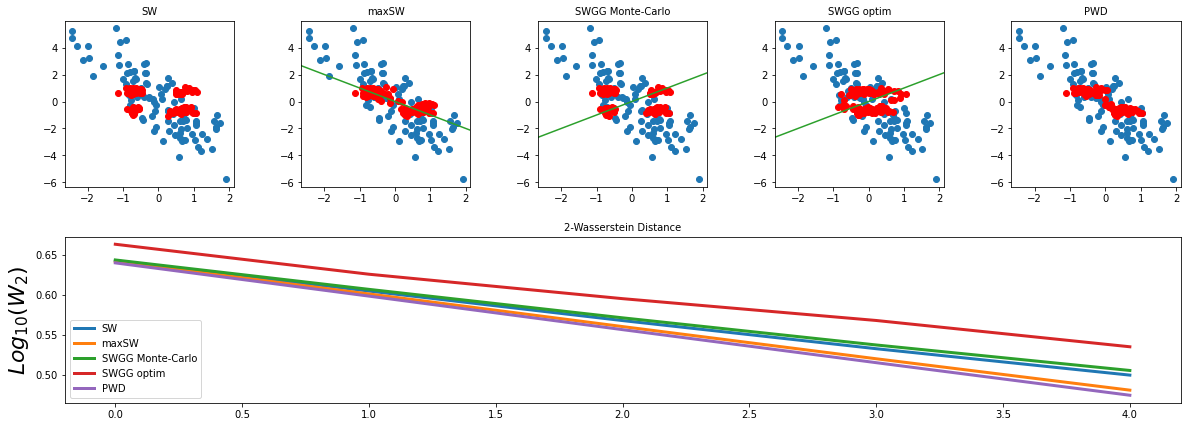

In [8]:
s=len(modes)

fig = pl.figure(figsize=(4*s, 8+3))
grid = pl.GridSpec(3, s, wspace=.4, hspace=0.3)

plot_fig = True

for i in range(nofiterations):
    print(i,end=' ')
    loss = list()
    theta = torch.ones(len(modes),d)
    
    #X = load_data(name=dataset_name, n_samples=N,dim=2)
    #X -= X.mean(dim=0)[np.newaxis,:]  # Normalization
    
    for k in range(s):
        # Loss computation
        loss_ = 0
        if k==0:
            loss_ += gsw_res[k].sw(X.to(device), Y[k],theta=None)
        
        if k==1:
            #print(X,Y[k])
            l,theta[k],loss_max=gsw_res[k].max_sw(X.to(device),Y[k],iterations=nb_iteration[k],lr=lear_rates[k])
            loss_ +=l
            
        if k==2:
            #l,theta[k] = gsw_res[k].SWGG_CP(X.to(device), Y[k].to(device),theta=None)
            #loss_+=l
            loss_ +=gsw_res[k].sw(X.to(device), Y[k].to(device),theta=None)
            
        if k==3:
            #l,theta[k],loss_min=gsw_res[k].get_minSWGG_smooth(X.to(device),Y[k].to(device),lr=lear_rates[k],num_iter=nb_iteration[k]
            #                                                  ,s=100,std=.5,init=theta[k])
            #loss_ +=l
            loss_ +=gsw_res[k].sw(X.to(device), Y[k].to(device),theta=None)
            
        if k==4:
            loss_ += gsw_res[k].PWD(X.to(device), Y[k],theta=None)
       
        # Optimization step
        loss.append(loss_)
        optimizer[k].zero_grad()
        loss[k].backward()
        optimizer[k].step()
        
        # Compute the 2-Wasserstein distance to compare the distributions
        if dist=='w2':
            w2_dist[i, k] = w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())
 
             
        theta2=theta.numpy()   
        if plot_fig:
            if k==0 or k==4:
                temp = Y[k].detach().cpu().numpy()
                pl.subplot(grid[k//s, k%s])
                pl.scatter(X[:,0], X[:,1])
                pl.scatter(temp[:,0], temp[:,1],c='r')
                pl.title(titles[k], fontsize=10)
                xlim1,xlim2=pl.xlim()
                ylim1,ylim2=pl.ylim()
            else :
                temp = Y[k].detach().cpu().numpy()
                pl.subplot(grid[k//s, k%s])
                pl.scatter(X[:,0], X[:,1])
                pl.scatter(temp[:,0], temp[:,1],c='r')
                pl.axline((0,0), theta2[k][0:2], color='C2')
                pl.xlim(xlim1,xlim2)
                pl.ylim(ylim1,ylim2)
                pl.title(titles[k], fontsize=10)
    #print(theta[k])
    if plot_fig:
    # Plot the 2-Wasserstein distance
        pl.subplot(grid[1, 0:s])
        pl.plot(np.log10(w2_dist[:,:]), linewidth=3)
        pl.title('2-Wasserstein Distance', fontsize=10)
        pl.ylabel(r'$Log_{10}(W_2)$', fontsize=22)
        pl.legend(titles, fontsize=10, loc='lower left')
        
        #plt.subplot(grid[2,:])
        #plt.title('Optimization of theta SWGG')
        #plt.plot(loss_min,c='C4',label='min SW')
        #plt.plot(loss_max,c='C0',label='max SW')
        #plt.legend()
        
        
        display.clear_output(wait=True)
        display.display(pl.gcf()) 
        time.sleep(1e-5)

        # Save the figure 
        fig.savefig(foldername + '/img%03d.png'%(i))
        for k in range(s):
            pl.subplot(grid[:, k])
            pl.cla()
            
            

# Cross Validate s and std

In [9]:
p=1
X_cut=X[:,0:2].data
Y_cut=Y[0][:,0:2].data
num_proj=360*p
thetas = np.linspace(0, 2*np.pi, num_proj)
dire = np.array([(np.cos(theta),np.sin(theta)) for theta in thetas])
dir_torch=torch.from_numpy(dire).to(device)

msw_theta = [SWGG_smooth(X_cut,Y_cut,p.float(),s=1,std=0) for p in dir_torch]
msw_theta_pos = [SWGG_smooth(X_cut,Y_cut,p.float(),s=100,std=.5) for p in dir_torch]


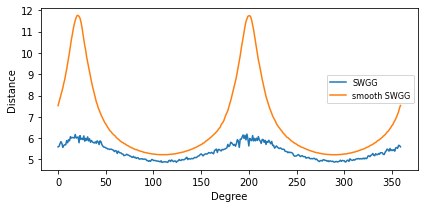

In [10]:
l=np.arange(0,360,1/p)
pl.figure(figsize=(6,3))
pl.plot(l,msw_theta, label="SWGG",c='C0')
pl.plot(l,msw_theta_pos, label="smooth SWGG",c='C1')
pl.xlabel('Degree')
pl.ylabel('Distance')
pl.tight_layout()
pl.legend(loc=5, prop={'size': 8})

100%|██████████████████████████| 100/100 [00:00<00:00, 395.84it/s, loss = 5.224]


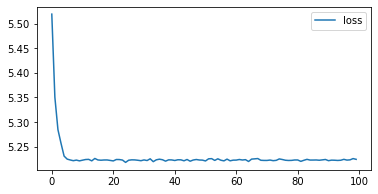

In [12]:
_,loss_l,_=get_SWGG_smooth(X_cut,Y_cut,lr=2e0,num_iter=100,s=100,std=.5)
pl.figure(figsize=(6,3))
pl.plot(loss_l, label="loss",c='C0')
pl.legend()

# To compute multiple GF

In [9]:
import numpy as np
import torch
from torch import optim
import ot
import pandas as pd
from tqdm import tqdm
from IPython import display
import time
import timeit
import matplotlib.pyplot as pl

In [10]:
import os
import sys
sys.path.append('../code/')

In [11]:
from gradient_flow import GF
from utils_GF import load_data,w2,upperW2_smooth,get_minSW_smooth

In [12]:
# Use GPU if available, CPU otherwise
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device='cpu'
print(device)

cpu


In [13]:
import importlib
import gradient_flow
importlib.reload(gradient_flow)

#Dataset
dataset_name = 'gaussian_2d'
N = 100  # Number of samples from p_X
d = 2

# Number of iterations for the optimization process
nofiterations = 3

modes = ['linear', 'linear', 'linear','linear']
titles = ['SW', 'maxSW','SWGG Monte-Carlo','SWGG optim']

lear_rates=[1e-2,1e-2,1e-2,1e-2]

nb_iteration = [1,200,1,200]
lr=[0,1e-2,0,1e-2]
n_proj = [500,1,500,1]
n_seed=2

W2_dist = np.zeros((n_seed,nofiterations, len(modes)))

In [14]:

for s in range(n_seed):
    print(s,end= ' ')
    np.random.seed(s)
    X = load_data(name=dataset_name, n_samples=N,dim=2)
    X -= X.mean(dim=0)[np.newaxis,:]  # Normalization
    meanX = 0
    temp = np.random.normal(loc=meanX, scale=.25, size=(N,d))
    # Define the optimizers
    Y = list()
    optimizer = list()
    gsw_res = list()
    
    for k in range(len(modes)):
        W2_dist[s,0,k]=w2(X.numpy(), temp)
        Y.append(torch.tensor(temp, dtype=torch.float, device=device, requires_grad=True))
        optimizer.append(optim.Adam([Y[k]], lr = lear_rates[k]))
        gsw_res.append(gradient_flow.GF(ftype=modes[k], nofprojections=n_proj[k],device=device))
        
    theta = torch.ones(len(modes),d)
    for i in range(1,nofiterations):
        loss = list()
        for k in range(len(modes)):
            loss_ = 0
            if k==0:
                loss_ += gsw_res[k].sw(X.to(device), Y[k].to(device),theta=None)

            if k==1:
                l,theta[k],_=gsw_res[k].max_sw(X.to(device),Y[k].to(device),iterations=nb_iteration[k],lr=lr[k])
                loss_ +=l 

            if k==2:
                l,theta[k] = gsw_res[k].SWGG_CP(X.to(device), Y[k].to(device),theta=None)
                loss_+=l

            if k==3:
                l,theta[k],_=gsw_res[k].get_minSWGG_smooth(X.to(device),Y[k].to(device),
                                                                  lr=lr[k],num_iter=nb_iteration[k],s=100,std=.5,init=theta[k])
                loss_ +=l
                
            loss.append(loss_)
            optimizer[k].zero_grad()
            loss[k].backward()
            optimizer[k].step()
            W2_dist[s,i, k] = w2(X.detach().cpu().numpy(), Y[k].detach().cpu().numpy())

0 

/home/gui/Documents/Thèse/Github/SWGG/Notebook/../code/utils_GF.py:90: RuntimeWarning: covariance is not positive-semidefinite.
  temp=np.random.multivariate_normal(mu_s, cov_s, N)
/home/gui/Documents/Thèse/Github/SWGG/Notebook/../code/gradient_flow.py:103: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  theta=torch.tensor(init,device=X.device, dtype=X.dtype,requires_grad=True)


1 

In [11]:
#np.savetxt("Results/Gradient_Flow/"+dataset_name+"_SW.txt",W2_dist[:,:,0])
#np.savetxt("Results/Gradient_Flow/"+dataset_name+"_maxSW.txt",W2_dist[:,:,1])
#np.savetxt("Results/Gradient_Flow/"+dataset_name+"_minSW_mc.txt",W2_dist[:,:,2])
#np.savetxt("Results/Gradient_Flow/"+dataset_name+"_minSW_opt.txt",W2_dist[:,:,3])